In [1]:
import matplotlib.pyplot as plt
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import string
from wordcloud import WordCloud

# Strategies
## Word focused
If the vocabulary is what you are looking at, the next step is to remove the punctuation and the stopwords. 

With the following code, we are going to generate a list of words used in the `Body` column. It won't be extremely useful for the classification task but comparing vocabulary can be very revealing (given the right subset: spam vs. regular emails,etc.).

Once we have a list of words, we can start the vocabulary analysis by coding a counter or using `FreqDist` from the `nltk` library for example.

In [2]:
df = pd.read_csv('data/processed/data.csv', index_col='Id')
df['Body'].fillna(value='code', inplace=True)

# Removing stopwords

In [3]:
stop_words = list(string.punctuation)
stop_words = list(string.whitespace)
stop_words += stopwords.words('english')

In [4]:
def nostop(text):
    words = text.split()
    words = [word.lower() for word in words if len(word) >= 3]
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

In [5]:
df['Body']=df['Body'].apply(lambda x: nostop(x))

# Word frequency for the whole dataset

In [6]:
allwords = {}
for observation in df['Body']:
    for word in observation.split():
        allwords[word] = allwords.get(word,0) + 1

Because of the way we cleaned the text, there is an over representation of the word "code". Lets' get rid of it. (It might be a good idea to see if there is any correlation between the quality of a question and how much code, if any, is posted)

In [7]:
allwords.pop('code')

331856

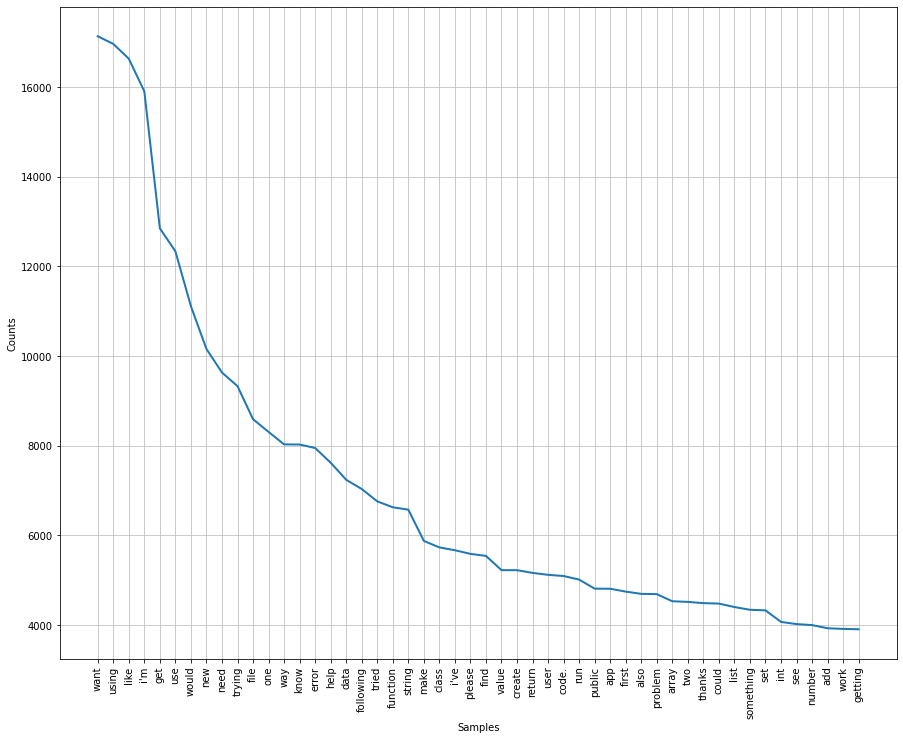

In [8]:
plt.figure(figsize=(15,12))
FreqDist(allwords).plot(50);

# Word frequency for the HQ questions

In [9]:
words_hq = {}
for observation in df['Body'][df['Y'] == 'HQ']:
    for word in observation.split():
        words_hq[word] = words_hq.get(word,0) + 1

In [10]:
words_hq.pop('code')

49901

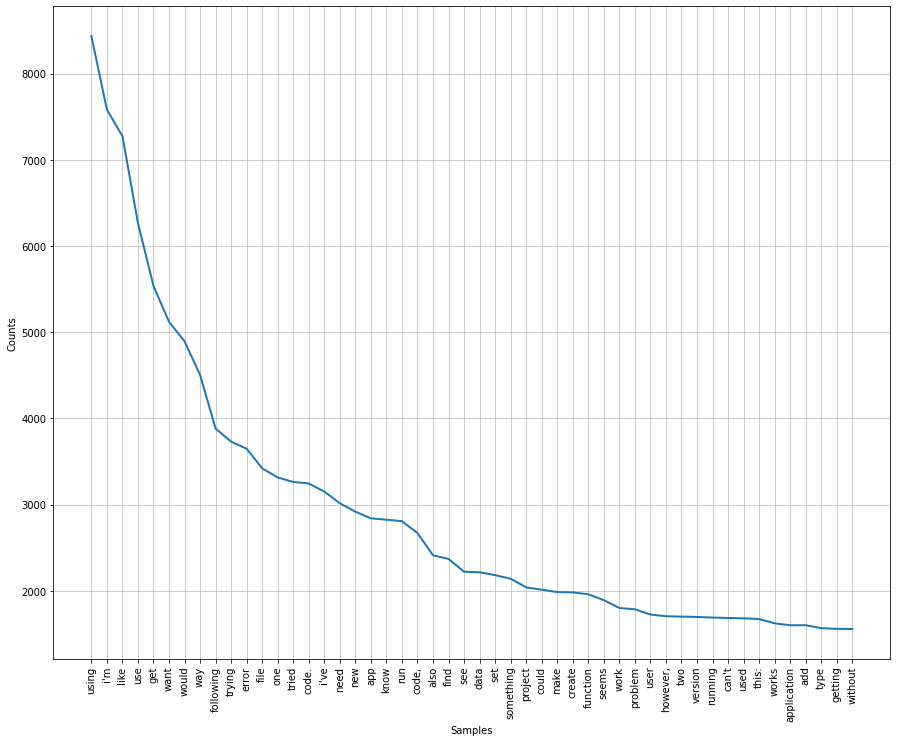

In [11]:
plt.figure(figsize=(15,12))
FreqDist(words_hq).plot(50);

## Word frequency for LQ_EDIT questions

In [12]:
words_lqe = {}
for observation in df['Body'][df['Y'] == 'LQ_EDIT']:
    for word in observation.split():
        words_lqe[word] = words_lqe.get(word,0) + 1

In [13]:
words_lqe.pop('code')

253297

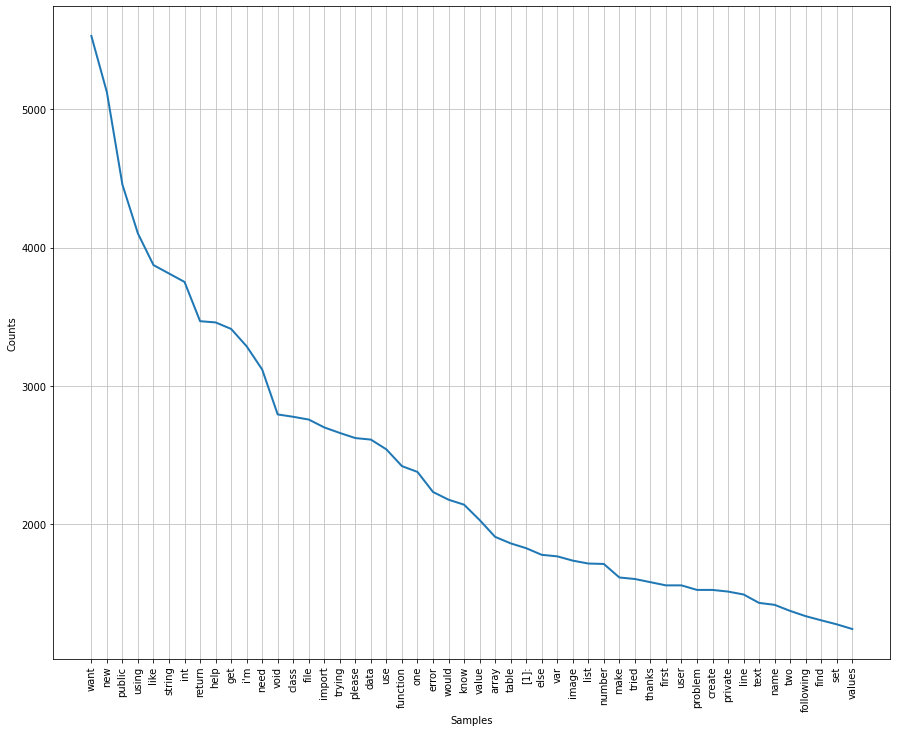

In [14]:
plt.figure(figsize=(15,12))
FreqDist(words_lqe).plot(50);

## Word frequency for LQ_CLOSE questions

In [15]:
words_lqc = {}
for observation in df['Body'][df['Y'] == 'LQ_CLOSE']:
    for word in observation.split():
        words_lqc[word] = words_lqc.get(word,0) + 1

In [16]:
words_lqc.pop('code')

28658

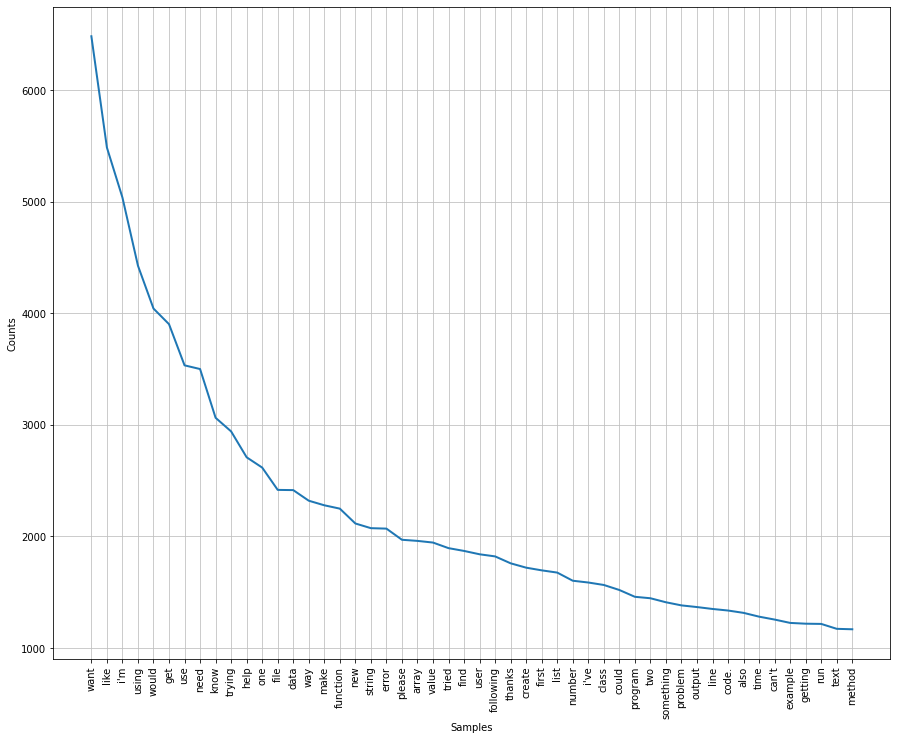

In [17]:
plt.figure(figsize=(15,12))
FreqDist(words_lqc).plot(50);

Or if you want to do a document analysis (like a TF-IDF type of analysis), you can use a lambda function to alter data in the dataframe.

## Wordcloud
Wordclouds are to text data what pie charts are to numerical data. They are at best confusing and at worst useless. But it can be generate a nice picture for your article header :)

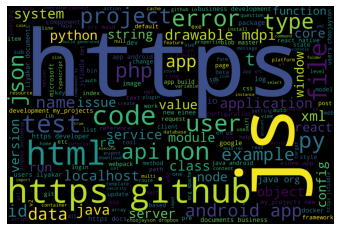

In [18]:
wordcloud = WordCloud(width = 3000,
                      height = 2000
                     )

wordcloud.generate(" ".join(words_hq.keys()))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

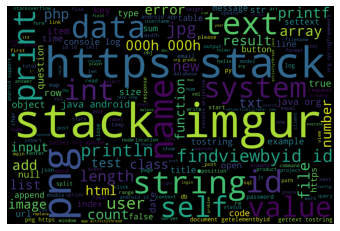

In [19]:
wordcloud = WordCloud(width = 3000,
                      height = 2000
                     )

wordcloud.generate(" ".join(words_lqe.keys()))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

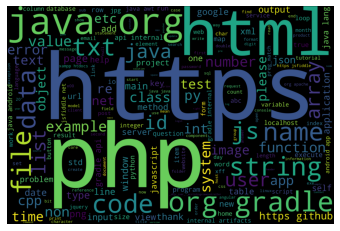

In [20]:
wordcloud = WordCloud(width = 3000,
                      height = 2000
                     )

wordcloud.generate(" ".join(words_lqc.keys()))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Stemming
This process is going to remove the ending of the words, shrinking them to their stem, their common denominator. For example, in the following list:
- programmer
- programmation
- programmed
- programming
- program
- programme

The stem of these words is **program**. It is easy to imagine a stemmed document being harder to read (by a human at least) but at the same time, it is going to be easier to compare different documents. This "normalization" is going to help make a model more robust as the ambiguity is reduced.

It is worth noting:
- there are a lot of stemming algorithms, available in various languages. [nltk.stem API module](https://www.nltk.org/api/nltk.stem.html) will give you a list of stemming classes available with NLTK.
- whilst stemming simplifies a document, it also creates "new" noise:  the stem for "flies" is "fli" for example.
- whilst stemming simplifies a document, it will induce a loss of information. For example, in the "program" list above, programme is the British spelling and program, the American spelling. If the origin of the review is not an important information for your analysis: Great, stemming has made this simpler! However if the localisation is key to your problem, you might miss some nuances by stemming your documents.

In [21]:
stemmer = SnowballStemmer("english")

In [22]:
def stem(document):
    stemmed = ''
    for word in document.split():
        stemmed += stemmer.stem(word) + ' '
        
    return stemmed

In [23]:
df['Stemmy'] = df['Body'].apply(lambda x:stem(x))

## Lemmatisation

In [24]:
wnl = WordNetLemmatizer()

In [25]:
def lem(document):
    lemmed =  ''
    for word in document.split():
        lemmed += wnl.lemmatize(word) + ' '
        
    return lemmed

In [26]:
df['Lemmy'] = df['Body'].apply(lambda x:lem(x))

In [27]:
df.to_csv('data/processed/data_with_stem_lem.csv')

In [28]:
df = pd.read_csv('data/processed/data_with_stem_lem.csv', index_col='Id')

# Body-Only Model

## X

In [29]:
df.fillna('code', inplace=True)

In [30]:
#Not sure if necessary yet
from tensorflow.keras.preprocessing.text import Tokenizer
token = Tokenizer()
token.fit_on_texts(df['Body'].values)
X = token.texts_to_sequences(df['Body'].values)

In [31]:
len(X)

60000

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 300
padded_X = pad_sequences(X, maxlen = max_length, padding = 'post')

In [33]:
print(padded_X.shape, ' ', padded_X, sep='\n')

(60000, 300)
 
[[   6  225 2264 ...    0    0    0]
 [ 106  662    2 ...    0    0    0]
 [ 319    2  135 ...    0    0    0]
 ...
 [1749  519    1 ...    0    0    0]
 [ 492  178   86 ...    0    0    0]
 [ 744 2500  182 ...    0    0    0]]


## y

In [34]:
y = pd.get_dummies(df['Y']).values

In [35]:
print(y.shape,' ', y, sep='\n')

(60000, 3)
 
[[0 1 0]
 [0 0 1]
 [1 0 0]
 ...
 [0 0 1]
 [0 1 0]
 [0 1 0]]


## Train Test Split

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(padded_X,
                                                    y,
                                                    test_size = 0.20,
                                                    random_state = 42
                                                   )

In [37]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(48000, 300) (48000, 3)
(12000, 300) (12000, 3)


## Training

In [38]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
model = Sequential()
model.add(Embedding(300, 100, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop', 
              metrics=['accuracy']
             )

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          30000     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 300, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 3)                 303       
Total params: 110,703
Trainable params: 110,703
Non-trainable params: 0
_________________________________________________________________
None


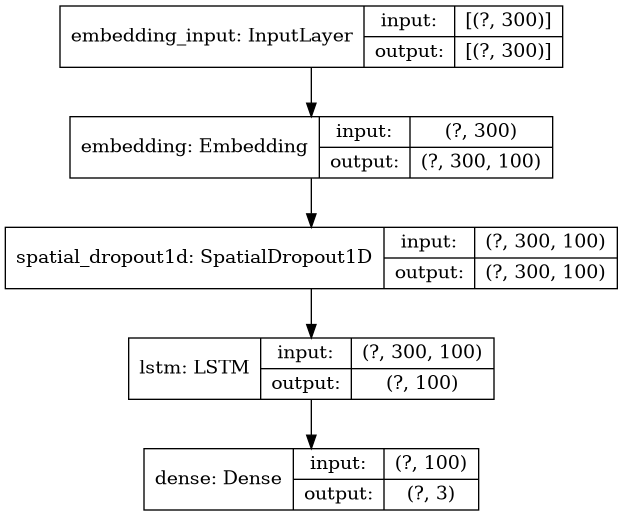

In [39]:
plot_model(model, to_file='data/img/BodyOnlyModel.png',show_shapes=True)

## Fitting

In [ ]:
history = model.fit(X_train,
                    Y_train,
                    epochs=50,
                    batch_size=64,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss',
                                             mode='min',
                                             verbose=1,
                                             patience=3, 
                                             min_delta=0.0001
                                            )
                              ]
                   )